# Topics Covered

- What does Encoder do?
- What is Self Attention
- Machine Learning enhanced Self Attention
- Masking in Self Attention

# Dependencies

In [1]:
import os

# Change Working Directory
abspath = os.path.abspath("../src/train.py")
dname = os.path.dirname(abspath)
os.chdir(dname)

print("Working from: ", dname)

Working from:  /home/rvn/projects/pet-projects/BardBungle/src


In [2]:
import numpy as np
import pandas as pd
import sentencepiece as spm
import torch
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from processing import src_processing, input_trg_processing, output_trg_processing
from transformer import Transformer

In [3]:
####################################
######### Loading Dataset ##########
####################################
df = pd.read_csv("../data/shk2mod.csv", index_col=0) # Loading the csv file
df.drop("id", axis=1, inplace=True)
d = df.to_numpy()           # Converting dataframe to numpy
src, trg = d[:,0], d[:,1]   # Splitting columns into source and target
print("SRC shape: {}; TRG shape: {}".format(src.shape, trg.shape))

####################################
######## Tokenizing Sentences ######
####################################
# Encoding src
shakespeare = spm.SentencePieceProcessor(model_file="../trained_models/tokenizer/shakespeare_en.model")
src_id = shakespeare.EncodeAsIds(list(src))
# Encoding trg
modern = spm.SentencePieceProcessor(model_file="../trained_models/tokenizer/modern_en.model")
trg_id = modern.EncodeAsIds(list(trg))
# Filter out small sequences
src_id_small = []
trg_id_small = []

for (src_snt, trg_snt) in zip(src_id, trg_id):
    if len(src_snt) <= 10 and len(trg_snt) <= 10:
        src_id_small.append(src_snt)
        trg_id_small.append(trg_snt)

src_id = src_id_small
trg_id = trg_id_small
####################################
##### Padding and Preprocessing ####
####################################
# Max Sequence Length
max_seq_len = 15
# Padding/Truncating src
src_id = [src_processing(id, max_seq_len) for id in src_id] 
# Padding/Truncating trg
input_trg_id = [input_trg_processing(id, max_seq_len) for id in trg_id] 
output_trg_id = [output_trg_processing(id, max_seq_len) for id in trg_id] 
# Moving everything to torch tensors
src_id = torch.tensor(src_id)
input_trg_id = torch.tensor(input_trg_id)
output_trg_id = torch.tensor(output_trg_id)
print("Src Shapes: {}; dtype: {}".format(src_id.shape, src_id.dtype))
print("Input Trg Shapes: {}; dtype: {}".format(input_trg_id.shape, input_trg_id.dtype))
print("Output Trg Shapes: {}; dtype: {}".format(output_trg_id.shape, output_trg_id.dtype))

####################################
########## Loading Model ###########
####################################
num_epochs = 3000
device = "cpu"
emb, heads, layers = 32, 4, 1
model = Transformer(emb=emb, heads=heads, max_seq_len=max_seq_len, 
                    src_vocab_len=shakespeare.vocab_size(), trg_vocab_len=modern.vocab_size(),
                    num_layers=layers, device=device).to(device)
model.load_state_dict(torch.load("../trained_models/model_emb{}_heads{}_layers{}.pt".format(emb, heads, layers)))

SRC shape: (51787,); TRG shape: (51787,)
Src Shapes: torch.Size([8809, 15]); dtype: torch.int64
Input Trg Shapes: torch.Size([8809, 15]); dtype: torch.int64
Output Trg Shapes: torch.Size([8809, 15]); dtype: torch.int64


<All keys matched successfully>

# Introduction

In the last chapter, I discussed dataset in great detail. Starting from  the raw strings, we saw how it is preprocessed into a sequence of integer tokens. These tokens are then fed into token embedding where each integer is mapped to a high dimensional vector (with some sense of language semantics). Finally, positional encoding adds the information related to the position of each token in the sequence. This was important because unlike Recurrent Neural Nets, Transformers accept and operate on the complete sequence in parallel.

In this chapter, I will spend some time discussing self attention. Starting from the very basic intuition of the operations behind self attention, I will build an Encoder network which processes the input shakespeare sentences and understand the context between different tokens.

# What is Attention

The purpose of Attention is to assign a "similarity score" between tokens in sequences. Let me explain this using a very simple example. Consider a sequence containing 5 different movies. Each movie has 3 attributes (comedy, adventure and animated) which can take values from -1 to 1. For instance, movie 1 is pure comedy so it's attributes would be something like [1, -1, -1]. However, another movie is animated with adventure and a bit of comedy. The attribute values in this case would look something like [0.2, 0.8, 1]. Similarly we have attribute values assigned to rest of the movies. The task here is to recommend movies to 3 different users with different movie preferences. Similar to the movies, these users can also be put into a sequence with attribute values representing their movie preferences.

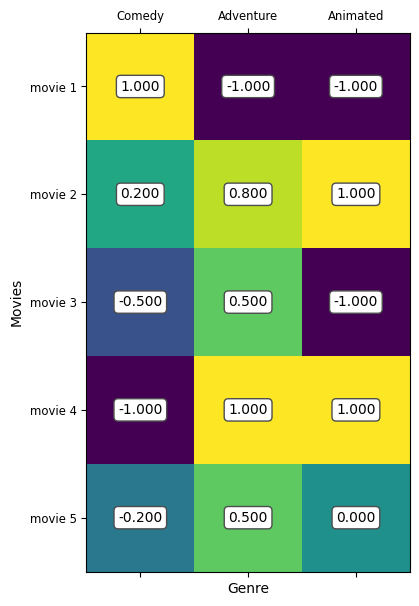

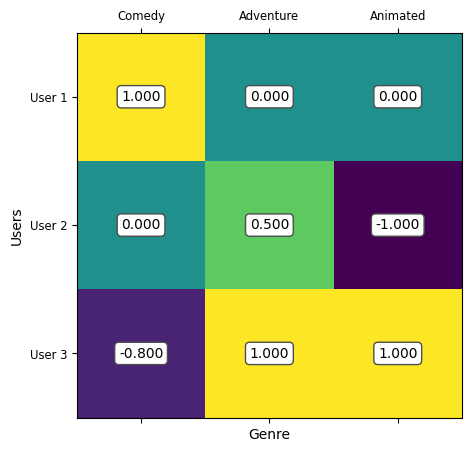

In [4]:
movies = np.array([[1, -1, -1],
                  [0.2, 0.8, 1],
                  [-0.5, 0.5, -1],
                  [-1, 1, 1],
                  [-0.2, 0.5, 0]])

plt.rcParams["figure.figsize"] = (5,7)
fig, ax = plt.subplots()
im = ax.matshow(movies)
text_objects = []
for (i, j), z in np.ndenumerate(movies):
    text = ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'), color="black")
    text_objects.append(text)
ax.set_yticks(range(movies.shape[0]), ["movie 1", "movie 2", "movie 3", "movie 4", "movie 5"], size='small')
ax.set_xticks(range(movies.shape[1]), ["Comedy", "Adventure", "Animated"], size='small')
ax.set_ylabel("Movies")
ax.set_xlabel("Genre")
plt.show()

users = np.array([[1, 0, 0],
                  [0, 0.5, -1],
                  [-0.8, 1, 1]])
plt.rcParams["figure.figsize"] = (5,5)
fig, ax = plt.subplots()
im = ax.matshow(users)
text_objects = []
for (i, j), z in np.ndenumerate(users):
    text = ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'), color="black")
    text_objects.append(text)
ax.set_yticks(range(users.shape[0]), ["User 1", "User 2", "User 3"], size='small')
ax.set_xticks(range(users.shape[1]), ["Comedy", "Adventure", "Animated"], size='small')
ax.set_ylabel("Users")
ax.set_xlabel("Genre")
plt.show()


How can we mathematically evaluate which user will like which movie more? The Answer is dot product!

If we premultiply the users matrix with the transpose of the movies matrix (i.e. match the attribute values in users against movies), we will get a score telling us how much a given user might like a movie.

```py
# Dot product between Users and Movie
score = users @ movies.T
```

This `score` could be any floating point number. It could end up being a very large number if there are more attribute values, so it's better to scale this by the square root of number of attributes (3 in this case). 

> Why $\sqrt{3}$? Its the Euclidean length of the vectors in the sequence. Therefore, we are dividing out the amount by which the increase in dimension increases the length of the average vectors.

```py
# Scaling down the score
score = score / (3**(1/2))
```

Now the score is scaled nicely and won't blow up as the number of attributes increase, but it would still be better to have this number between 0 and 1. This is done by applying row wise softmax to the score matrix. 

> Why row wise softmax? We want to analyse how a user would like different movies, hence scores across a set user need to sum up to 1.

```py
# Row wise Softmax
score = F.softmax(score, dim=-1)
```

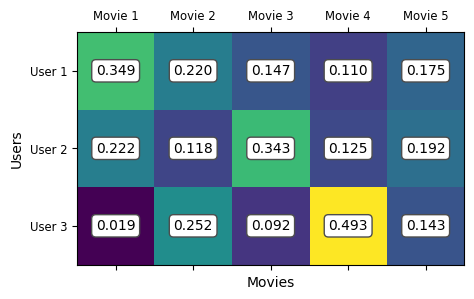

In [5]:
# Dot Product
score = users @ movies.T
# Scaling
score = score / (len(users)**(1/2))
# Row wise Softmax
score = F.softmax(torch.tensor(score), dim=-1).numpy()

plt.rcParams["figure.figsize"] = (5,5)
fig, ax = plt.subplots()
im = ax.matshow(score)
text_objects = []
for (i, j), z in np.ndenumerate(score):
    text = ax.text(j, i, '{:0.3f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'), color="black")
    text_objects.append(text)
ax.set_yticks(range(score.shape[0]), ["User 1", "User 2", "User 3"], size='small')
ax.set_xticks(range(score.shape[1]), ["Movie 1", "Movie 2", "Movie 3", "Movie 4", "Movie 5"], size='small')
ax.set_ylabel("Users")
ax.set_xlabel("Movies")
plt.show()

# Adding Machine Learning to Self Attention

This concept can be applied straight to our dataset. Instead of the sequence of users, we just have a sequence of tokens in a sentence. The task for our Transformer is to understand the context between different tokens in this sentence, so the same sequence of tokens replace the sequence of movies as well. 

> Remember that the attributes of a token in this case are generated by the Token Embedding and Positional Encoding layers.

-------------------Shakespeare Dataset-------------------------
Original Sentence:   You do not meet a man but frowns: 
Tokenized Sentence:  ['You', 'do', 'not', 'meet', 'a', 'man', 'but', 'frown', 's', ':', '[EOS]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
Numericalized Sentence:  tensor([ 107,   48,   23,  427,   12,   87,   50, 1530,    6,   26,    2,    0,
           0,    0,    0])
Attention Weights for the sentence: 


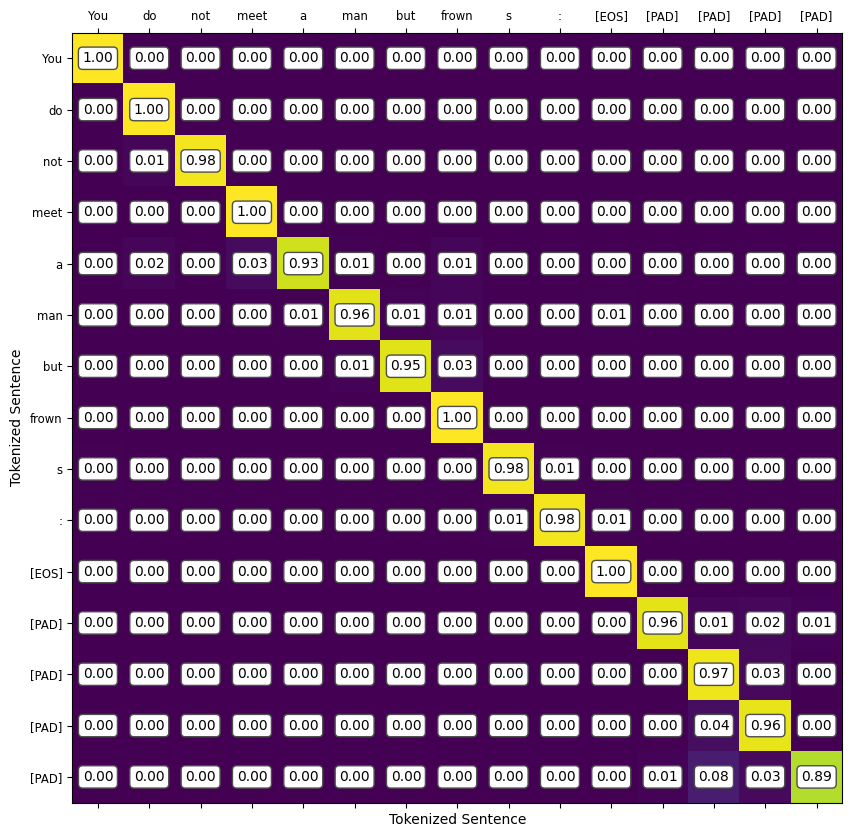

In [4]:
# Token Embeddings and positional encoding layers from a trained transformer
src_token_emb = model.src_token_emb
src_pos_enc = model.src_pos_emb

plt.rcParams["figure.figsize"] = (12,10)

# Example Sentence
print("-------------------Shakespeare Dataset-------------------------")
print("Original Sentence: ", src[0])
tokens = shakespeare.EncodeAsPieces(src[0])
tokens += ["[EOS]"] # EOS Token string
tokens = (tokens + max_seq_len * ['[PAD]'])[:max_seq_len] # Padding Tokens string
tokens = [piece.lstrip('▁') for piece in tokens]
print("Tokenized Sentence: ", tokens)

print("Numericalized Sentence: ", src_id[0])

print("Attention Weights for the sentence: ")
fig, ax = plt.subplots()
# Token Embedding
data = src_token_emb(src_id) 
# Positional Encoding
b, t, emb = data.shape
data = data + src_pos_enc(torch.arange(t, device=device))[None, :, :].expand(b, t, emb)
# Attention Weights
W = torch.matmul(data[0], data[0].transpose(-2,-1))
W = W / (emb**(1/2))
W = F.softmax(W, dim=-1)

im = ax.matshow(W.detach().numpy())
# Create text objects to display the values
text_objects = []
for (i, j), z in np.ndenumerate(W.detach().numpy()):
    text = ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'), color="black")
    text_objects.append(text)
ax.set_yticks(range(len(tokens)), tokens, size='small')
ax.set_xticks(range(len(tokens)), tokens, size='small')
ax.set_ylabel("Tokenized Sentence")
ax.set_xlabel("Tokenized Sentence")
plt.show()

Now to embed this contextual information, weight matrix is multiplied with the original sequence matrix.

Modified sentence: 


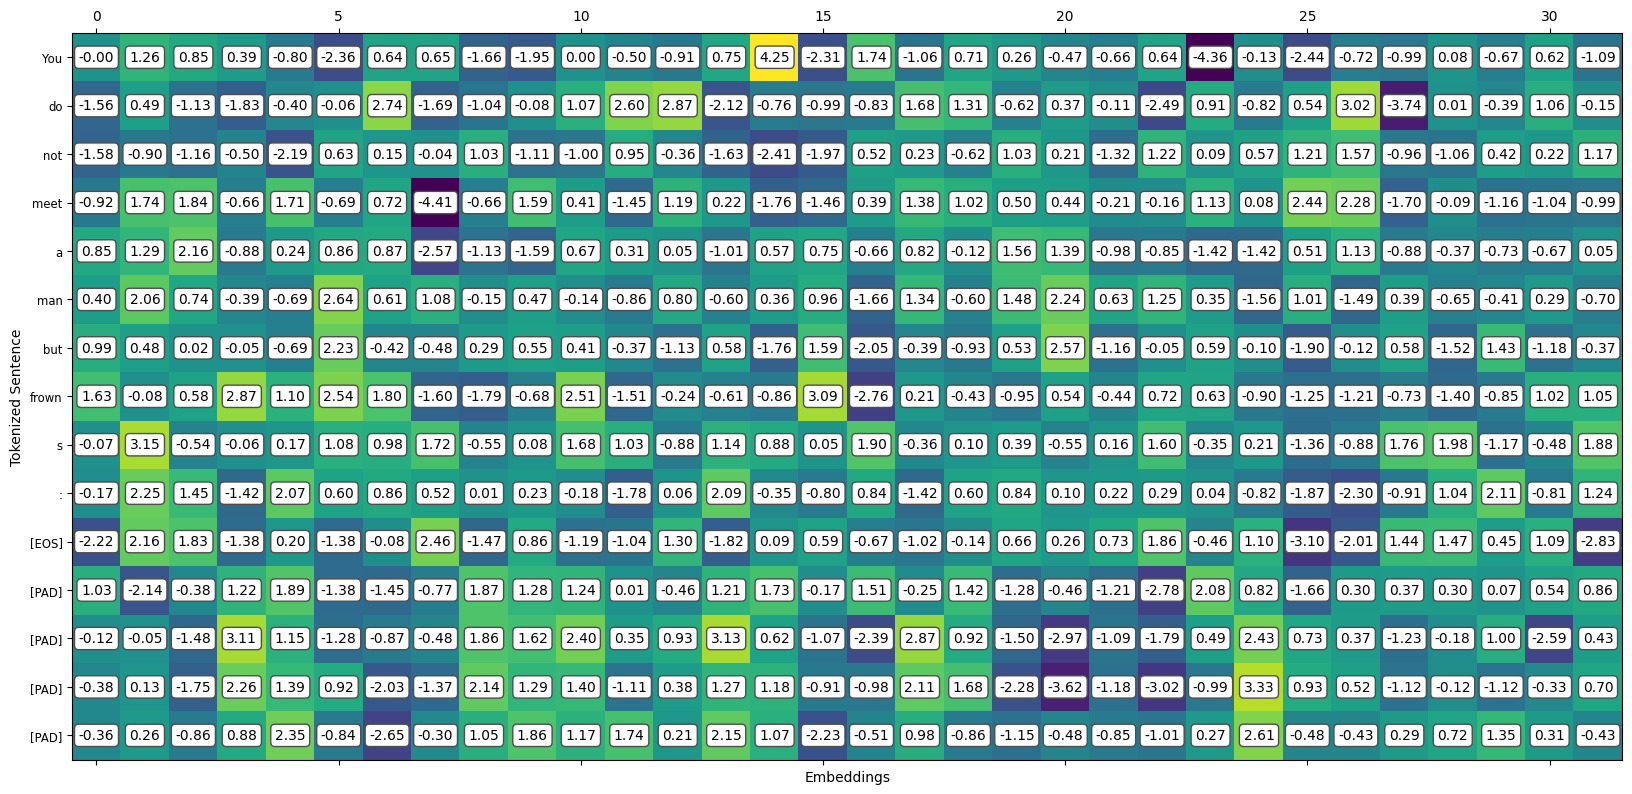

In [5]:
# Embedding the contextual information to generate the modified sequence
y = torch.matmul(W, data[0])

print("Modified sentence: ")
plt.rcParams["figure.figsize"] = (20,10)
fig, ax = plt.subplots()
im = ax.matshow(y.detach().numpy())
# Create text objects to display the values
text_objects = []
for (i, j), z in np.ndenumerate(y.detach().numpy()):
    text = ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'), color="black")
    text_objects.append(text)
ax.set_yticks(range(len(tokens)), tokens, size='small')
ax.set_ylabel("Tokenized Sentence")
ax.set_xlabel("Embeddings")
plt.show()

You might have noticed a problem with the weight matrix. Each token is only attending to itself! That's not very useful. We need a mechanism that learns the context automatically based on the provided dataset. This is where we incorporate machine learning into the self attention operation.

Instead of using the sequence of token `x` as it is, we send it through three different neural nets (with learnable parameters) and collect the outputs. Let's call these `queries`, `keys` and `values`.

```py
queries = torch.nn.Linear(emb, emb)(x)
keys = torch.nn.Linear(emb, emb)(x)
values = torch.nn.Linear(emb, emb)(x)
```

These outputs are then used to get attention weights, which in turn modifies the input sequence (`values`) such that it contains the context between different tokens.

```py
W = torch.matmul(queries, keys.transpose(-2,-1)) # Computing Weights
W = W / (self.emb**(1/2)) # Scaling for stability
W = F.softmax(W, dim=-1) # Row-wise Softmax
y = torch.matmul(W, values) # Computing y
```

In [6]:
W = []
y = []
for epoch in range(0, num_epochs, 1):
    model.load_state_dict(torch.load("../trained_models/nn_models/model_emb{}_heads{}_layers{}_ep{}.pt".format(emb, heads, layers, epoch)))

    # Self Attention Layer
    self_attention = model.encoder[0].self_attention

    # Output and attention weights
    y.append(self_attention(data[0].unsqueeze(0)))
    W.append(self_attention.attention_weights)

In [7]:
@widgets.interact(epoch=(0, num_epochs-1, 50))
def plot_attention_weights(epoch):
    plt.rcParams["figure.figsize"] = (10,10)
    fig, ax = plt.subplots()
    w_num=1
    im = ax.matshow(W[epoch][0, w_num].detach().numpy())
    # Create text objects to display the values
    text_objects = []
    for (i, j), z in np.ndenumerate(W[epoch][0, w_num].detach().numpy()):
        text = ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'), color="black")
        text_objects.append(text)
    ax.set_yticks(range(len(tokens)), tokens, size='small')
    ax.set_xticks(range(len(tokens)), tokens, size='small')
    ax.set_ylabel("Tokenized Sentence")
    ax.set_xlabel("Tokenized Sentence")
    plt.show()

interactive(children=(IntSlider(value=1450, description='epoch', max=2999, step=50), Output()), _dom_classes=(…

In [8]:
print("Modified sentence: ")
@widgets.interact(epoch=(0, num_epochs-1, 50))
def plot_modified_output(epoch):
    plt.rcParams["figure.figsize"] = (20,10)
    fig, ax = plt.subplots()
    im = ax.matshow(y[epoch][0].detach().numpy())
    # Create text objects to display the values
    text_objects = []
    for (i, j), z in np.ndenumerate(y[epoch][0].detach().numpy()):
        text = ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'), color="black")
        text_objects.append(text)
    ax.set_yticks(range(len(tokens)), tokens, size='small')
    ax.set_ylabel("Tokenized Sentence")
    ax.set_xlabel("Embeddings")
    plt.show()

Modified sentence: 


interactive(children=(IntSlider(value=1450, description='epoch', max=2999, step=50), Output()), _dom_classes=(…

# Masking in Self Attention

There is a minor issue with the attention operation mentioned above. If you look carefully, there are a few instances when a token is attending to the padding tokens. while this is not too bad, but ideally we would like our attention operation to ignore these tokens all together. This is done by masking the weights corresponding to the padding tokens.

The very first step is to define a mask. This is fairly easy because the padding tokens are represented using the integer 0, and in a single line of code, I can identify the positions where there's a padding token.

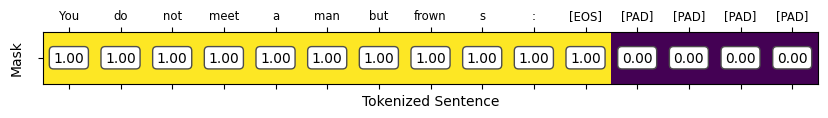

In [9]:
# Generate Mask
e_mask = (src_id != 0).unsqueeze(1).to(device)

plt.rcParams["figure.figsize"] = (10,10)
fig, ax = plt.subplots()
im = ax.matshow(e_mask[0].detach().numpy())
# Create text objects to display the values
text_objects = []
for (i, j), z in np.ndenumerate(e_mask[0].detach().numpy()):
    text = ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
            bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'), color="black")
    text_objects.append(text)
ax.set_xticks(range(len(tokens)), tokens, size='small')
ax.set_xlabel("Tokenized Sentence")
ax.set_yticks(range(1), " ", size='small')
ax.set_ylabel("Mask")
plt.show()

To insure that each token does not attend to the padding tokens, we mask the padding token weights by setting those values to $- \infty$ before softmax is applied. So, the attention operation with masking looks like

```py
W = torch.matmul(queries, keys.transpose(-2,-1)) # Computing Weights
W = W / (self.emb**(1/2)) # Scaling for stability
# Applying Mask
if mask is not None:
    mask = mask.unsqueeze(1) # (b, 1, t) => (b, 1, 1, t) or (b, t, t) => (b, 1, t, t)
    W = W.masked_fill_(mask == 0, -1e+10)
W = F.softmax(W, dim=-1) # Row-wise Softmax
y = torch.matmul(W, values) # Computing y
```

In [11]:
W = []
y = []
for epoch in range(0, num_epochs, 1):
    model.load_state_dict(torch.load("../trained_models/nn_models/model_emb{}_heads{}_layers{}_ep{}.pt".format(emb, heads, layers, epoch)))

    # Self Attention Layer
    self_attention = model.encoder[0].self_attention

    # Output and attention weights
    y.append(self_attention(data[0].unsqueeze(0), e_mask[0]))
    W.append(self_attention.attention_weights)

In [12]:
@widgets.interact(epoch=(0, num_epochs-1, 50))
def plot_attention_weights(epoch):
    plt.rcParams["figure.figsize"] = (10,10)
    fig, ax = plt.subplots()
    w_num=1
    im = ax.matshow(W[epoch][0, w_num].detach().numpy())
    # Create text objects to display the values
    text_objects = []
    for (i, j), z in np.ndenumerate(W[epoch][0, w_num].detach().numpy()):
        text = ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'), color="black")
        text_objects.append(text)
    ax.set_yticks(range(len(tokens)), tokens, size='small')
    ax.set_xticks(range(len(tokens)), tokens, size='small')
    ax.set_ylabel("Tokenized Sentence")
    ax.set_xlabel("Tokenized Sentence")
    plt.show()

interactive(children=(IntSlider(value=1450, description='epoch', max=2999, step=50), Output()), _dom_classes=(…

In [13]:
print("Modified sentence: ")
@widgets.interact(epoch=(0, num_epochs-1, 50))
def plot_modified_output(epoch):
    plt.rcParams["figure.figsize"] = (20,10)
    fig, ax = plt.subplots()
    im = ax.matshow(y[epoch][0].detach().numpy())
    # Create text objects to display the values
    text_objects = []
    for (i, j), z in np.ndenumerate(y[epoch][0].detach().numpy()):
        text = ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'), color="black")
        text_objects.append(text)
    ax.set_yticks(range(len(tokens)), tokens, size='small')
    ax.set_ylabel("Tokenized Sentence")
    ax.set_xlabel("Embeddings")
    plt.show()

Modified sentence: 


interactive(children=(IntSlider(value=1450, description='epoch', max=2999, step=50), Output()), _dom_classes=(…

# Multi-head Self Attention

If you look carefully at the attention weights, for each token you can see that the network is missing a lot of context (it is catching some but missing a lot as well). To give network another chance at understanding the context, we can use a multi-head attention. What this means is that, multiple self attentions are computed in parallel on the same input sentence.

![NaiveSA](figs/NaiveMulti-headAttention.jpg "NaiveSA")

The above figure shows how 5 self attention operations are applied in parallel on the same input sentences. 
- Each self attention block has 3 neural nets with trainable parameters (one each to get queries, keys and values), which leads to the total number of learnable parameters to: $3 \times \text{emb} \times \text{emb}$ (where `emb` is the embedding dimension which I have set as 32 in this blog post). 
- For `h` self attentions operations, the total number of learnable parameters increase to: $h \times 3 \times \text{emb} \times \text{emb}$. 
- The next step is to concatenate the outputs from these `h` heads and then send it through a linear layer so that the dimension of the output sequence is same as the input. This results in the total number of learnable parameters increasing to: $h \times 3 \times \text{emb} \times \text{emb} + h \times \text{emb} \times \text{emb}$. 

The big issue with the above formulation of multi-head attention is that it scales linearly with the number of heads. If we use a large `h`, the resulting computations will take a lot of computational resources. It turns out that there is a trick with which we can perform multi-head self attention and keep the number of learnable parameters to around $3 \times \text{emb} \times \text{emb}$.

## Efficient Multi-head Self Attention

![ESA](figs/Efficient-MHSA.jpg "ESA")
The above figure illustrates the efficient multi-head self attention. The trick here is that we compute the queries, keys and values matrices (which requires nerual net operations and has learnable parameters) once on the input sentences. These 3 matrices are then sliced and sent to parallel self attention operations. This results in the number of trainable parameters to be fixed at $3 \times \text{emb} \times \text{emb} + \text{emb} \times \text{emb}$ (no matter how many heads there are). I should mention that there is an additional slicing operation involved but that can't be avoided and is totally worth it considering we can use a really large `h` number and still keep the computational resources under control.

```py
class MultiHeadSelfAttention(torch.nn.Module):
    def __init__(self, emb, heads):
        super().__init__()
        assert emb % heads == 0
        self.emb, self.heads = emb, heads

        # Three emb x emb matrix multiplications to get queries, keys and values
        self.to_queries = torch.nn.Linear(emb, emb)
        self.to_keys = torch.nn.Linear(emb, emb)
        self.to_values = torch.nn.Linear(emb, emb)

        # One last Linear layer at the end with emb x emb matrix multiplication
        self.unify = torch.nn.Linear(emb, emb)

    def masked_attention(self, queries, keys, values, mask=None):
        W = torch.matmul(queries, keys.transpose(-2,-1)) # Computing Weights
        W = W / (self.emb**(1/2)) # Scaling for stability
        # Applying Mask
        if mask is not None:
            mask = mask.unsqueeze(1) # (b, 1, t) => (b, 1, 1, t) or (b, t, t) => (b, 1, t, t)
            W = W.masked_fill_(mask == 0, -1e+10)
        W = F.softmax(W, dim=-1) # Row-wise Softmax
        y = torch.matmul(W, values) # Computing y

        self.attention_weights = W

        return y

    def forward(self, x, mask=None):
        b, t, emb = x.shape # Batch Size, Sequence Length, embedding dim
        h = self.heads
        k = emb//h

        # Computing queries, keys and values
        queries = self.to_queries(x)
        keys = self.to_keys(x)
        values = self.to_values(x)

        # Slicing out the heads
        queries = queries.view(b, t, h, k)
        keys = keys.view(b, t, h, k)
        values = values.view(b, t, h, k)

        # Putting heads next to batch dims (Remember head computations can run in parallel)
        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        # Here comes Attention...
        y = self.masked_attention(queries, keys, values, mask)
        
        # Concat heads
        y = y.transpose(1, 2).reshape(b, t, emb) # Concatenating heads

        # Final Linear NN Layer
        return self.unify(y)
```

In [14]:
W = []
y = []
for epoch in range(0, num_epochs, 1):
    model.load_state_dict(torch.load("../trained_models/nn_models/model_emb{}_heads{}_layers{}_ep{}.pt".format(emb, heads, layers, epoch)))

    # Self Attention Layer
    self_attention = model.encoder[0].self_attention

    # Output and attention weights
    y.append(self_attention(data[0].unsqueeze(0), e_mask[0]))
    W.append(self_attention.attention_weights)

In [17]:
@widgets.interact(epoch=(0, num_epochs-1, 50), w_num=(0, 3, 1))
def plot_attention_weights(epoch, w_num):
    plt.rcParams["figure.figsize"] = (10,10)
    fig, ax = plt.subplots()
    w_num=w_num
    im = ax.matshow(W[epoch][0, w_num].detach().numpy())
    # Create text objects to display the values
    text_objects = []
    for (i, j), z in np.ndenumerate(W[epoch][0, w_num].detach().numpy()):
        text = ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'), color="black")
        text_objects.append(text)
    ax.set_yticks(range(len(tokens)), tokens, size='small')
    ax.set_xticks(range(len(tokens)), tokens, size='small')
    ax.set_ylabel("Tokenized Sentence")
    ax.set_xlabel("Tokenized Sentence")
    plt.show()

interactive(children=(IntSlider(value=1450, description='epoch', max=2999, step=50), IntSlider(value=1, descri…

# Encoder 

Multi-head self attention is one part of the encoder. Encoder is divided into multiple encoder layers, where each layer consists of a multi-head self attention supported by other blocks like layer normalization, dropout, multi layer perceptron, etc. These additional blocks provide the necessary muscle to the multi-head self attention so that it can process longer and complex sequences. 

```py
class EncoderLayer(torch.nn.Module):
    def __init__(self, emb, heads):
        super().__init__()
        # Normalization Layer 
        self.norm1 = torch.nn.LayerNorm([emb])
        
        # MultiHead Attention
        self.self_attention = MultiHeadSelfAttention(emb, heads)

        # Dropout Layer
        self.dropout1 = torch.nn.Dropout(0.1)

        # Normalization Layer
        self.norm2 = torch.nn.LayerNorm([emb])

        # FCN
        self.fcn = torch.nn.Sequential(
            torch.nn.Linear(emb, 4*emb),
            torch.nn.ReLU(),
            # torch.nn.Dropout(0.1),
            torch.nn.Linear(4*emb, emb)
        )

        # Dropout Layer
        self.dropout2 = torch.nn.Dropout(0.1)

        # Normalization Layer
        self.norm3 = torch.nn.LayerNorm([emb])

    def forward(self, x, e_mask):
        x_1 = self.norm1(x) # LayerNorm
        x_1 = self.self_attention(x_1, e_mask) # Attention 
        x_1 = self.dropout1(x_1) # Dropout
        x = x + x_1 # Skip Connection
        x_2 = self.norm2(x) # LayerNorm
        x_2 = self.fcn(x_2) # FCN
        x_2 = self.dropout2(x_2) # Dropout
        x = x + x_2 # Skip Connection
        x = self.norm3(x)
        return x
```

With the encoder layer defined, we can call this multiple times inside the transformer to process the input shakespeare sentences.

```py
class Transformer(torch.nn.Module):
    def __init__(self, emb, heads, max_seq_len, src_vocab_len, trg_vocab_len, num_layers=6, device="cpu"):
        super().__init__()
        # Device and layers
        self.num_layers = num_layers
        self.device = device
        
        # Token Embeddings
        self.src_token_emb = torch.nn.Embedding(num_embeddings=src_vocab_len, embedding_dim=emb)
        self.trg_token_emb = torch.nn.Embedding(num_embeddings=trg_vocab_len, embedding_dim=emb)

        # Positional Embeddings
        self.src_pos_emb = torch.nn.Embedding(num_embeddings=max_seq_len, embedding_dim=emb)
        self.trg_pos_emb = torch.nn.Embedding(num_embeddings=max_seq_len, embedding_dim=emb)

        # Encoder
        self.encoder = torch.nn.ModuleList([EncoderLayer(emb, heads) for _ in range(num_layers) ])

        # Decoder

        # Generator

    def forward(self, src_in, trg_in, e_mask=None, d_mask=None):
        # SRC Tokenized and pos embedded
        src_in = self.src_token_emb(src_in) 
        b, t, emb = src_in.shape
        src_in = src_in + self.src_pos_emb(torch.arange(t, device=self.device))[None, :, :].expand(b, t, emb)
        
        # TRG Tokenized and pos embedded
        trg_in = self.trg_token_emb(trg_in) 
        b, t, emb = trg_in.shape
        trg_in = trg_in + self.trg_pos_emb(torch.arange(t, device=self.device))[None, :, :].expand(b, t, emb)
        
        # Encoder
        for i in range(self.num_layers):
            src_in = self.encoder[i](src_in, e_mask)
        
        # Decoder
        
        # Generator
        

        return out
```